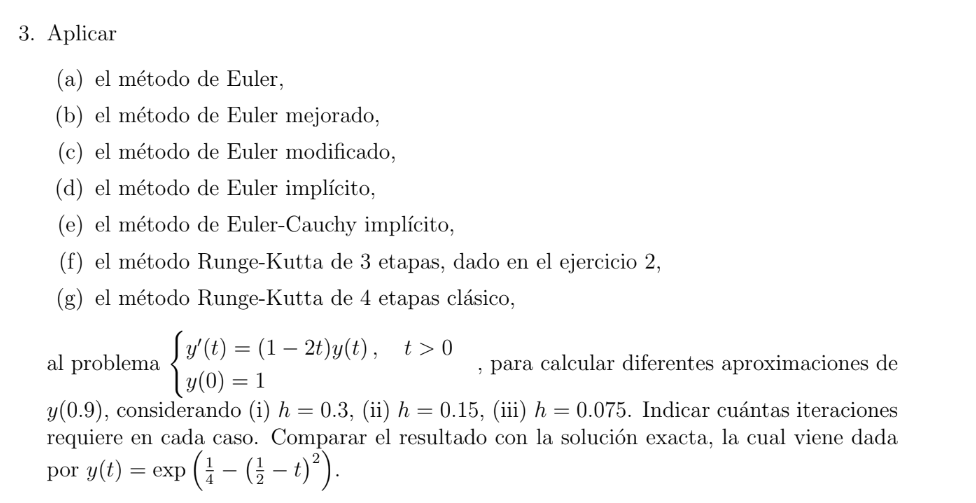

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [119]:
def dy_dt(t, y):
    return (1 - 2 * t) * y

def analytical(t, **kwargs):
    return math.exp((1/4) - (1/2 - t)**2)


def approximate_with_method(method, h, t0, tf, y0):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros_like(t_values)
    y_values[0] = y0
    for j in range(len(t_values) - 1):
        dy = dy_dt(t_values[j], y_values[j])
        y_values[j + 1] = method(yj=y_values[j], h=h, dy=dy, t=t_values[j], dy_dt=dy_dt)
    return t_values, y_values

def plot_approximation_results(
    method, method_name, h_values, t0, tf, y0
):
    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"{method_name} Method", fontsize="xx-large")

    markers = ["o", "s", "^", "x", "d", "*", "p", "h", "+", "|"]

    # Plot numerical solutions for each h
    for i, h in enumerate(h_values):
        t_values, y_aprox = approximate_with_method(method, h, t0, tf, y0)
        axes[0].plot(
            t_values,
            y_aprox,
            label=f"h = {h}",
            marker=markers[i % len(markers)],  # Cycle through markers if more h_values
            linestyle="",
            markersize="3",
        )
        axes[1].plot(t_values, y_aprox, label=f"h = {h}")

    # Plot the analytical solution for reference
    h = 0.001  # High precision for analytical solution
    t_values, y_analytical = approximate_with_method(analytical, h, t0, tf, y0)
    axes[1].plot(t_values, y_analytical, label="analytical")

    # Apply consistent formatting to all subplots
    for ax in axes:
        ax.set_xlabel("time (t)")
        ax.set_ylabel("y(t)")
        ax.legend()
        ax.grid()

    plt.show()


In [120]:
# given values, re used for all methods

h_values = [0.3, 0.15, 0.0075]
t0 = 0
tf =  0.9
y0 = 1

## Number of iterations (for each h)

In [121]:
for h in h_values:
    t_values = np.arange(t0, tf + h, h)
    print(f'For h={h}, there are {len(t_values)} steps. From {t_values[0]} to {t_values[-1]}')

For h=0.3, there are 4 steps. From 0.0 to 0.8999999999999999
For h=0.15, there are 8 steps. From 0.0 to 1.05
For h=0.0075, there are 121 steps. From 0.0 to 0.8999999999999999


## Euler method
### $y_{j+1} = y_{j} + hf(x_{j}, y_{j})$

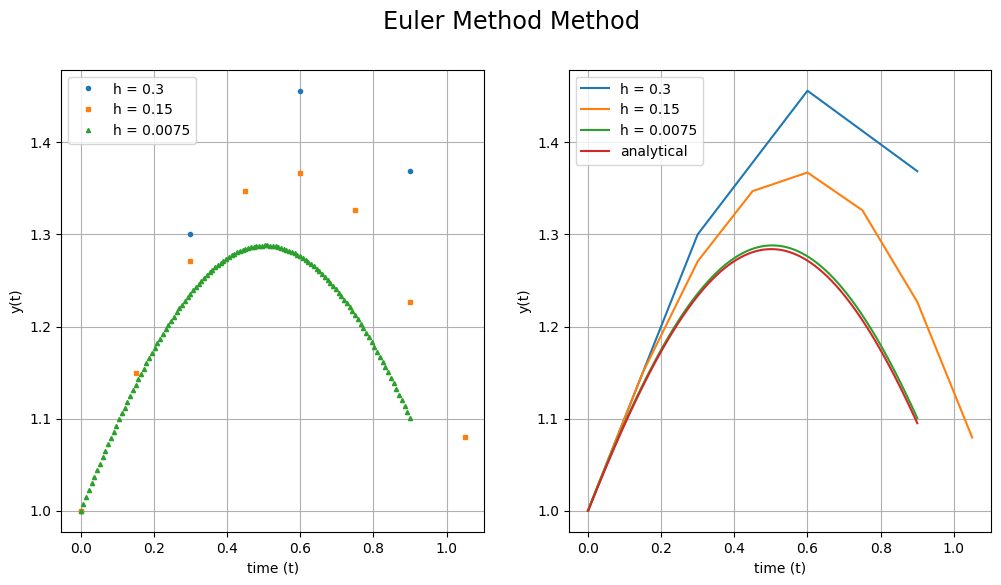

In [122]:

def euler(yj, h, dy, **kwargs):
    return yj + h * dy

plot_approximation_results(
    method=euler,
    method_name="Euler Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)

## Improved Euler (Heun's method)

### $y_{j+1} = y_j + \frac{h}{2} \left( f(t_j, y_j) + f\left(t_{j+1}, y_j + h f(t_j, y_j)\right) \right)$



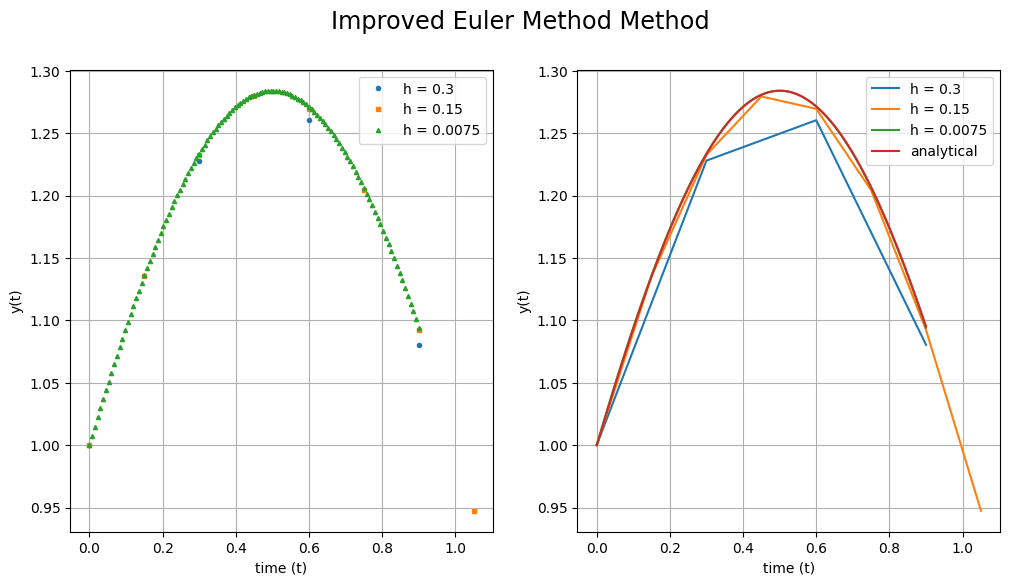

In [123]:
def improved_euler(yj, h, dy, t, dy_dt):
    # Predictor step (euler)
    predictor = euler(yj, h, dy)
    # Corrector step: y_next = yn + (h / 2) * [f(tn, yn) + f(tn+1, y_predict)]
    corrected = yj + (h / 2) * (dy + dy_dt(t + h, predictor))
    return corrected

plot_approximation_results(
    method=improved_euler,
    method_name="Improved Euler Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)

## Modified Euler (Midpoint method)

### $y_{j+1} = y_j + h f\left(t_j + \frac{h}{2}, y\left(t_j + \frac{h}{2}\right)\right)$

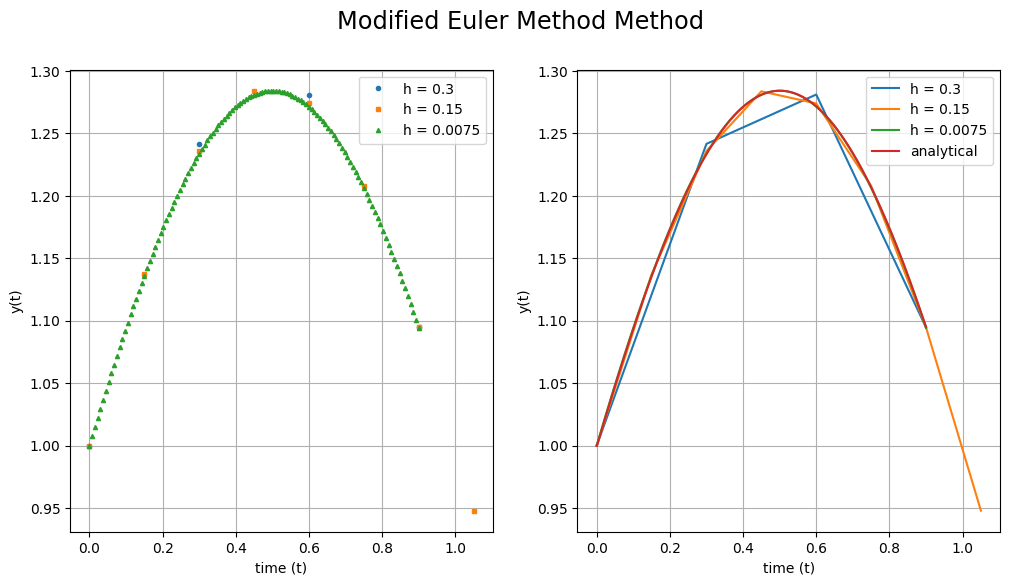

In [124]:
def modified_euler(yj, h, dy, t, dy_dt):
    # Calculate the midpoint values
    t_mid = t + h / 2
    y_mid = yj + (h / 2) * dy
    # Use the slope at the midpoint to compute the next value
    return yj + h * dy_dt(t_mid, y_mid)


plot_approximation_results(
    method=modified_euler,
    method_name="Modified Euler Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)

## Implicit Euler (Backwards Euler)
### $y_{j+1} = y_j + h f(t_{j+1}, y_{j+1})$

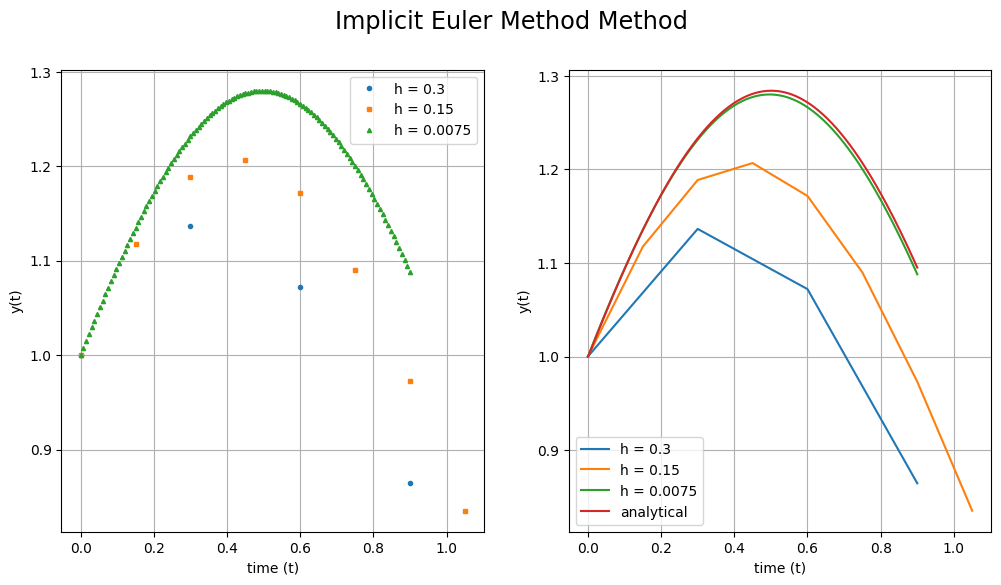

In [125]:
def implicit_euler(yj, h, t, dy_dt, tol=1e-6, max_iter=100, **kwargs):
    # Initial guess for y_{j+1} (use y_j as the initial guess)
    y_next = yj

    for _ in range(max_iter):
        # Evaluate the function g(y) = y - yj - h * f(t + h, y), where y =  yj+1
        g = y_next - yj - h * dy_dt(t + h, y_next)
        # Approximate g'(y) = 1 - h * (1 - 2  * tj+1) (partial derivative of f w.r.t. y)
        g_prime = 1 - h * (1 - 2 * t + h)  # Specific derivative for this example

        # apply Newton's Method
        y_new = y_next - g / g_prime

        if abs(y_new - y_next) < tol:
            return y_new

        # Update y_next for the next iteration
        y_next = y_new

    raise ValueError("Newton's Method did not converge")

plot_approximation_results(
    method=implicit_euler,
    method_name="Implicit Euler Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)

## Implicit Euler-Cauchy (Trapezoidal Rule)
### $y_{j+1} = y_j + \frac{h}{2} \left( f(t_j, y_j) + f(t_{j+1}, y_{j+1}) \right)$

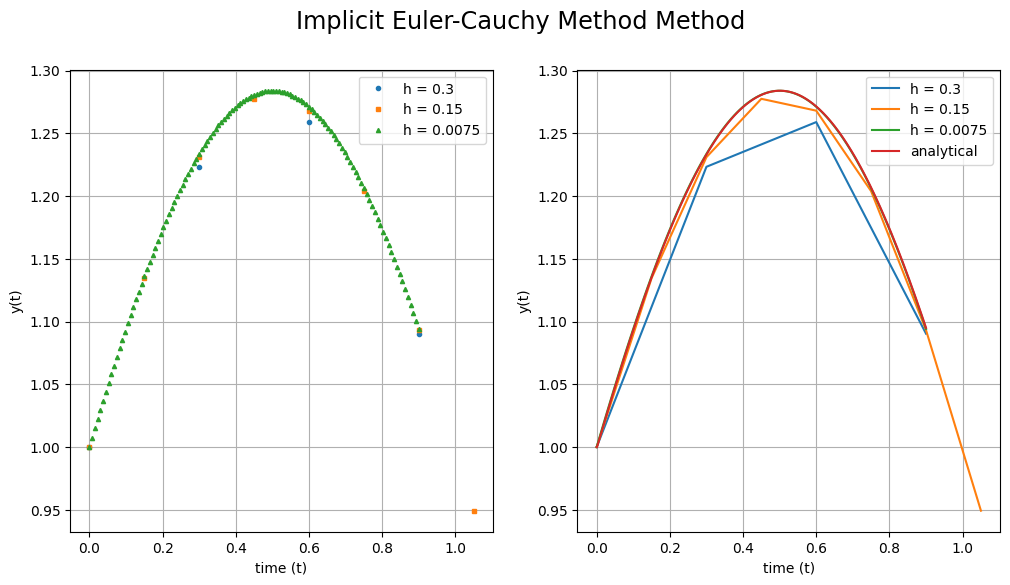

In [126]:
def euler_cauchy_implicit(yj, h, t, dy_dt, tol=1e-6, max_iter=100, **kwargs):
    # Initial guess for y_{j+1} (use y_j as the initial guess)
    y_next = yj

    for _ in range(max_iter):
        # Evaluate the function g(y) = y - yj - (h/2) * [f(tj, yj) + f(t + h, y)]
        g = y_next - yj - (h / 2) * (dy_dt(t, yj) + dy_dt(t + h, y_next))

        # Compute g'(y) = 1 - (h/2) * (partial derivative of f w.r.t y)
        g_prime = 1 - (h / 2) * (1 - 2 * (t + h))  # Derivative for this example

        # apply Newton's Method
        y_new = y_next - g / g_prime

        if abs(y_new - y_next) < tol:
            return y_new

        # Update y_next for the next iteration
        y_next = y_new

    raise ValueError("Newton's Method did not converge")

plot_approximation_results(
    method=euler_cauchy_implicit,
    method_name="Implicit Euler-Cauchy Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)


## 3 Stage Runge-Kutta

### $y_{n+1} = y_n + h \phi(t_n, y_n, h)$

where

### $\phi(t, y, h) = \frac{1}{8} \left[ 2k_1 + 3k_2 + 3k_3 \right]$

and

### $k_1 = f(t, y), \quad$
### $k_2 = f\left(t + \frac{2h}{3}, y + \frac{2h}{3}k_1\right), \quad$
### $k_3 = f\left(t + \frac{2h}{3}, y + \frac{2h}{3}k_2\right)$

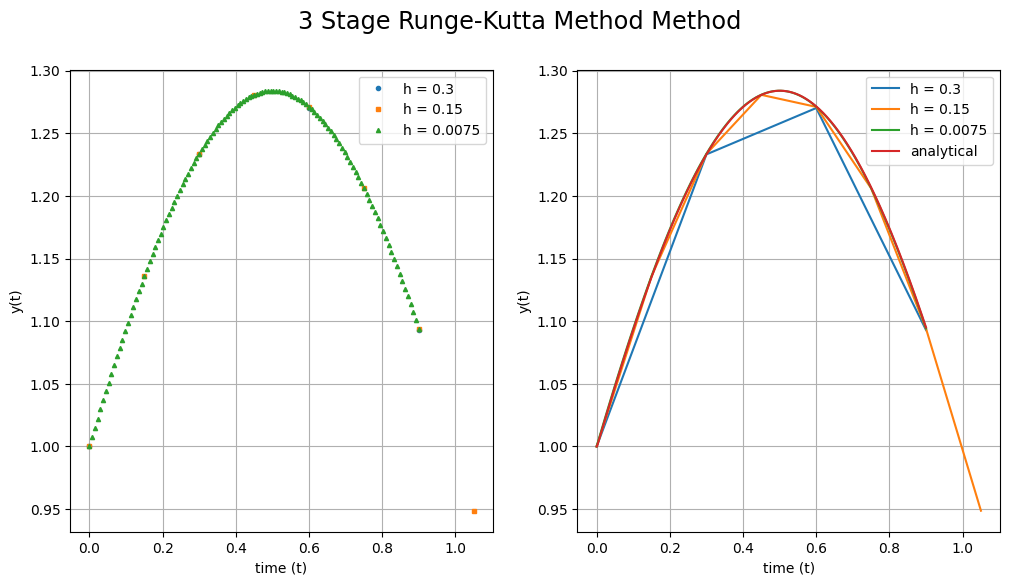

In [127]:
def runge_kutta_3_stage(yj, t, h, dy_dt, **kwargs):
    # Stage 1
    k1 = dy_dt(t, yj)

    # Stage 2
    k2 = dy_dt(t + (2 / 3) * h, yj + (2 / 3) * h * k1)

    # Stage 3
    k3 = dy_dt(t + (2 / 3) * h, yj + (2 / 3) * h * k2)

    # Combine stages to compute yj_{n+1}
    phi = (1 / 8) * (2 * k1 + 3 * k2 + 3 * k3)
    y_next = yj + h * phi

    return y_next


plot_approximation_results(
    method=runge_kutta_3_stage,
    method_name="3 Stage Runge-Kutta Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)


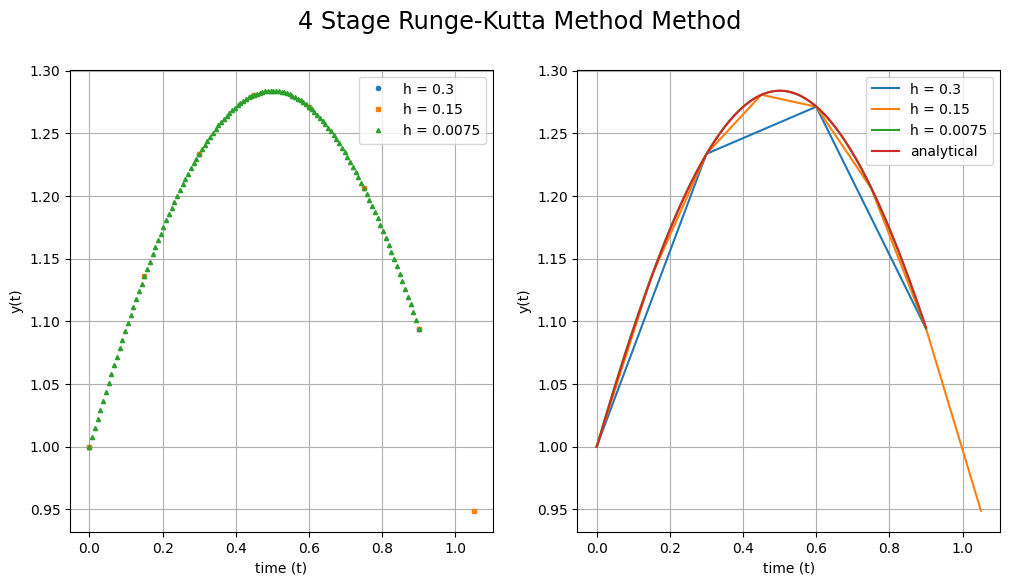

In [128]:
def runge_kutta_4_stage(yj, t, h, dy_dt, **kwargs):
    # Stage 1
    k1 = dy_dt(t, yj)

    # Stage 2
    k2 = dy_dt(t + h / 2, yj + h / 2 * k1)

    # Stage 3
    k3 = dy_dt(t + h / 2, yj + h / 2 * k2)

    # Stage 4
    k4 = dy_dt(t + h, yj + h * k3)

    # Combine stages to compute yj_{n+1}
    phi = (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    y_next = yj + h * phi

    return y_next


plot_approximation_results(
    method=runge_kutta_4_stage,
    method_name="4 Stage Runge-Kutta Method",
    h_values=h_values,
    t0=t0,
    tf=tf,
    y0=y0,
)
